# P&ID Object Detection and OCR Analysis Tool

# Table of Contents

1. [YOLO](#yolo)
2. [Neural Network Classification](#neural-network-classification) & [Neural Network Output](#neural-network-output)
3. [Data Augmentation](#data-augmentation)
4. [Explore classes](#explore-classes)
5. [Train the model](#train-the-model)
6. [Detect Objects/Classes](#detect-objectsclasses)
7. [Preprocess detected objects](#preprocess-detected-objects)
8. [RapidOCR Extractor](#rapidocr-extractor)


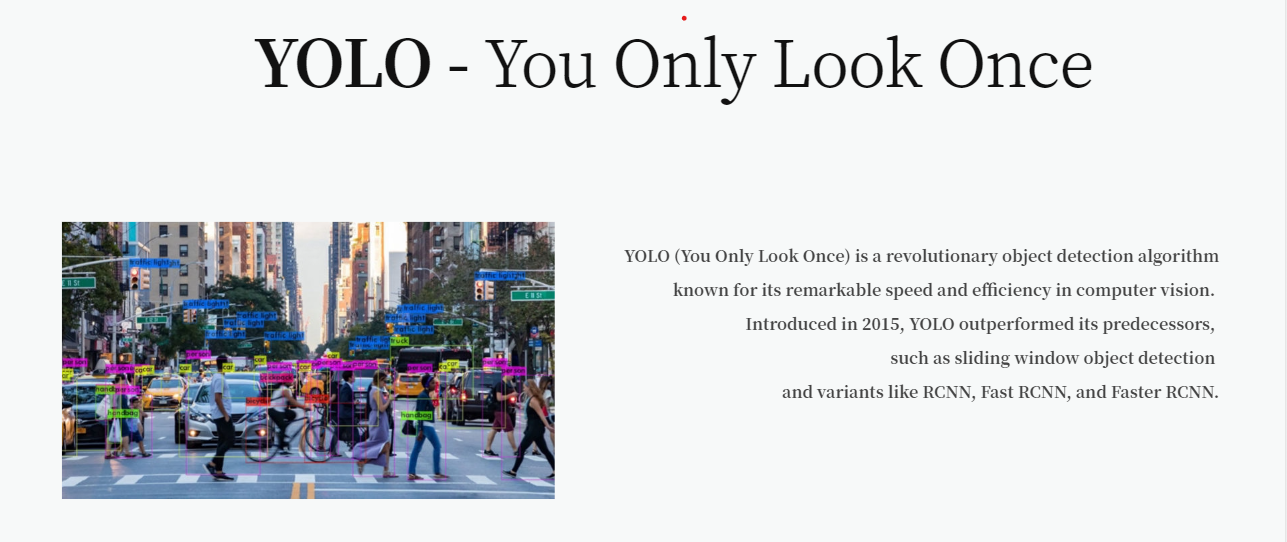

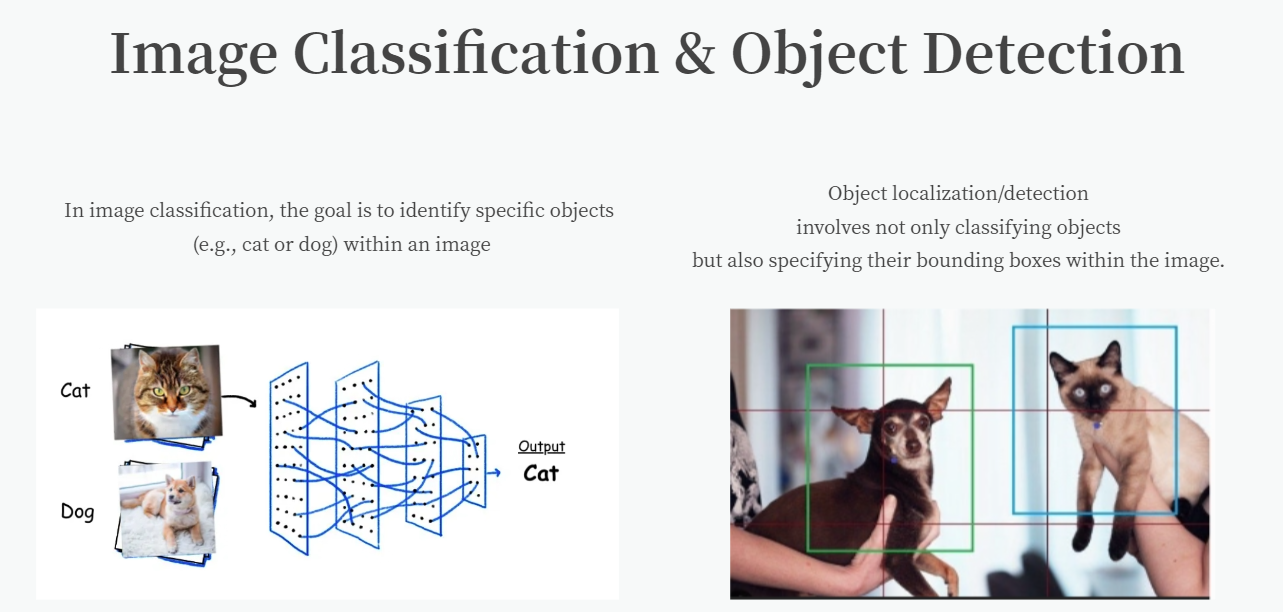

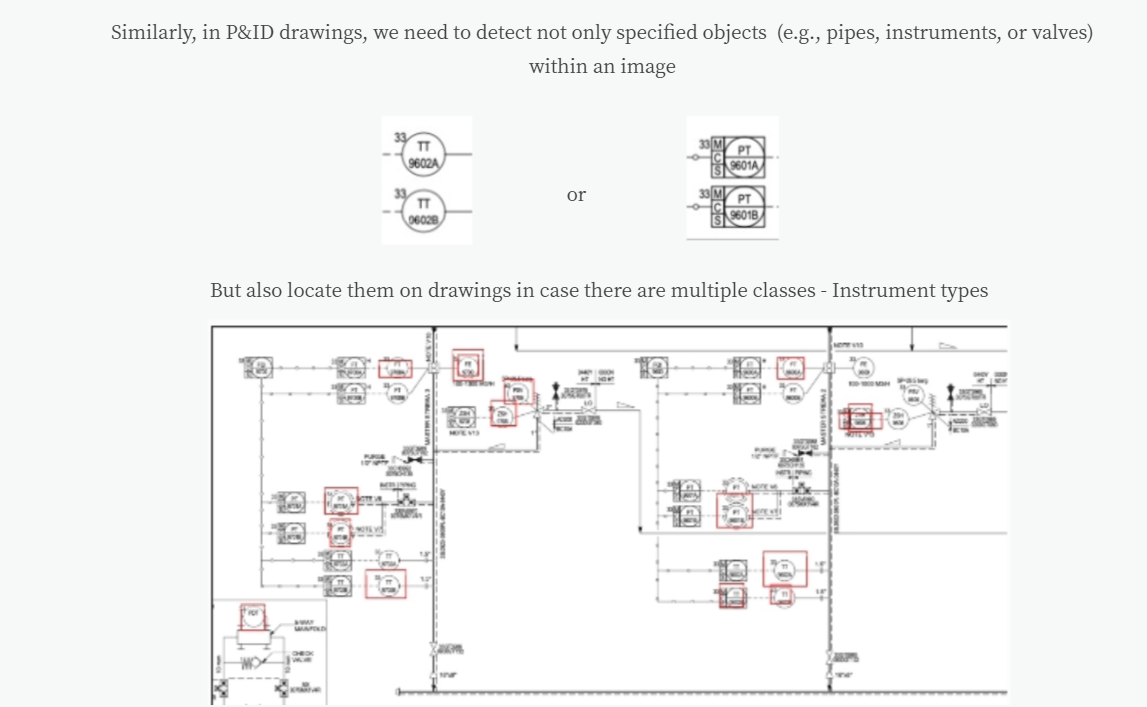

In [1]:
#install Rise
!pip install RISE
!jupyter-nbextension install rise --py --sys-prefix
!jupyter nbextension enable rise --py --sys-prefix

Installing C:\Users\Tsitsi\anaconda3\Lib\site-packages\rise\static -> rise
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\main.css
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\main.js
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\README.md
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\rise.png
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\rise.yaml
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\reveal.js\.travis.yml
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\reveal.js\bower.json
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\reveal.js\CONTRIBUTING.md
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\reveal.js\demo.html
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\rise\reveal.js\gruntfile.js
Up to date: C:\Users\Tsitsi\anaconda3\share\jupyter\nbextensions\ri

Enabling notebook extension rise/main...
      - Validating: ok


# Import necessary libraries

In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import shutil
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

# Create Project Directory and Set up environment

In [2]:
project_dir = r'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'
os.makedirs(project_dir, exist_ok=True)

In [3]:
pwd

'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'

In [4]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install scikit-image
!pip install streamlit
!pip install matplotlib
!pip install ipywidgets
!pip install fitz
!pip install frontend
!pip install pillow==9.3
!pip install PyMuPDF
!pip install pdfplumber
!pip install rapidocr_onnxruntime
!pip install craft-text-detector

  Using cached Pillow-9.3.0-cp311-cp311-win_amd64.whl (2.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


  You can safely remove it manually.


  Using cached craft_text_detector-0.4.3-py3-none-any.whl (18 kB)
  Using cached opencv-python-4.5.4.60.tar.gz (89.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [19 lines of output]
  Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
  Ignoring numpy: markers 'python_version <= "3.9" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
  Ignoring numpy: markers 'python_version <= "3.9" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.9" and platform_machine != "aarch64" and platform_machine != "arm64"' d

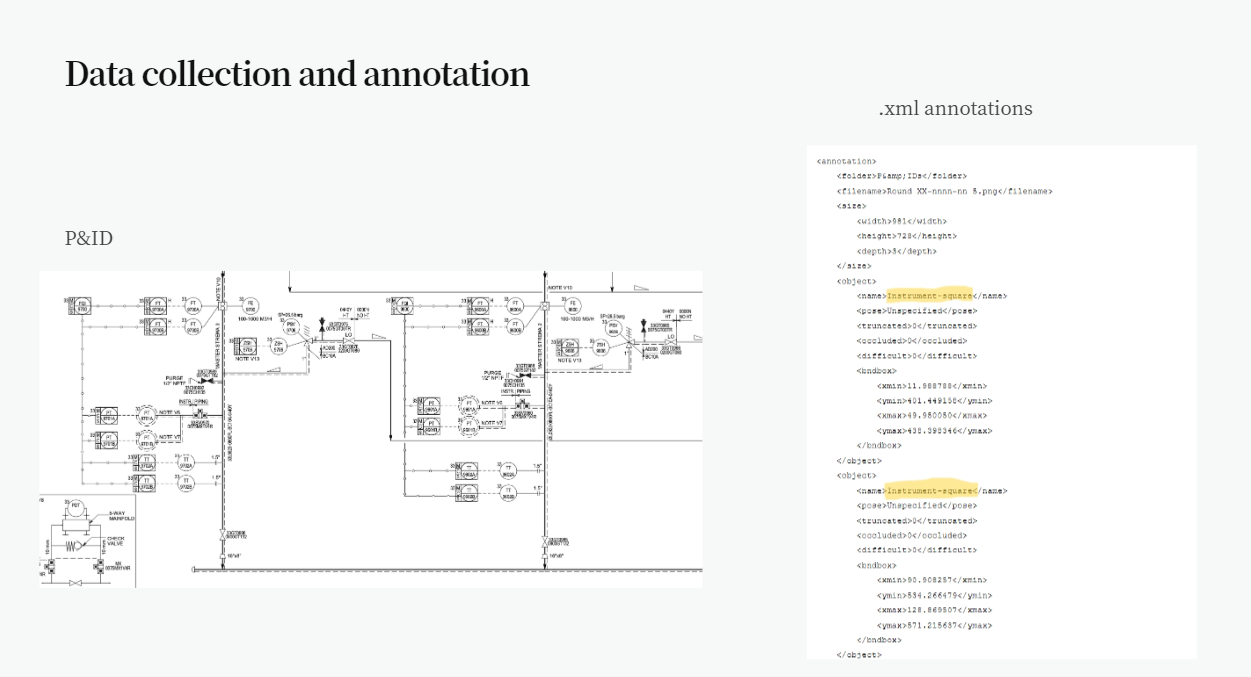

# Data Augmentation
The augmentation process in the application is designed to increase the diversity of the training dataset, thereby enabling the model to learn from a broader range of variations and conditions and predict better.

## Augmented images

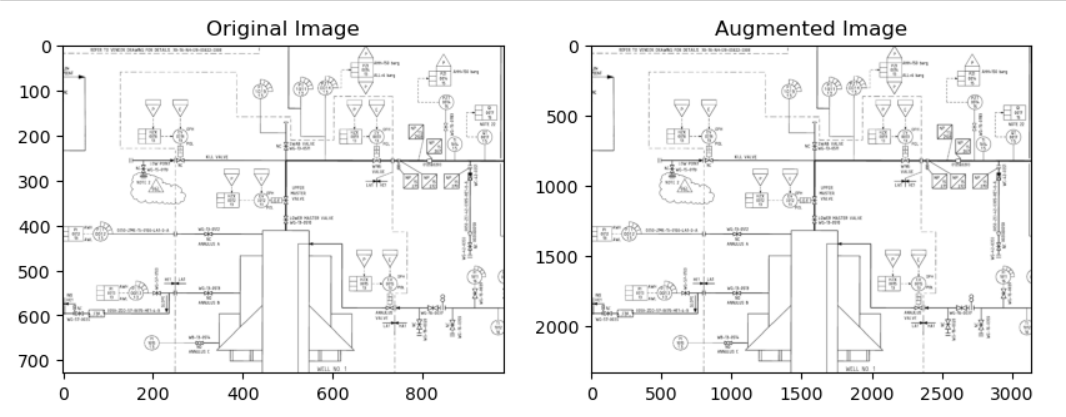

# Explore Classes

### P&ID images are annotated with three classes: 
- Instrument
- Instrument-offset
- Instrument-square


In [5]:
import os
import matplotlib.pyplot as plt

# Class mapping from your provided class map
class_map = {
    '0': 'Instrument',
    '1': 'Instrument-square',
    '2': 'Instrument-offset',
    '3': 'Instrument-square-offset'
}

def get_classes_from_txt(txt_file_path):
    class_counts = {name: 0 for name in class_map.values()}  # Initialize count for each class
    with open(txt_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id = line.split()[0]
            class_name = class_map[class_id]
            class_counts[class_name] += 1
    return class_counts

def accumulate_class_counts(directory):
    total_class_counts = {name: 0 for name in class_map.values()}  # Initialize count for each class
    for file in os.listdir(directory):
        if file.endswith('.txt'):
            txt_file_path = os.path.join(directory, file)
            class_counts = get_classes_from_txt(txt_file_path)
            for class_name, count in class_counts.items():
                total_class_counts[class_name] += count
    return total_class_counts

def plot_class_distribution(class_counts):
    # Unpack the class names and counts into separate lists for plotting
    class_names = list(class_counts.keys())
    instances = list(class_counts.values())

    plt.bar(class_names, instances, color='orange')
    plt.xlabel('Class Name')
    plt.ylabel('Instances')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Correct path usage
project_dir = 'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'
src_folder = os.path.join(project_dir, 'yolo\\labels\\train')   
directory = src_folder

# Check if the source directory exists before proceeding
if os.path.exists(directory):
    total_class_counts = accumulate_class_counts(directory)
    plot_class_distribution(total_class_counts)
else:
    print(f"The directory {directory} does not exist.")


The directory C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo\labels\train does not exist.


Files and classes

In [6]:
def get_classes_from_xml(xml_file_path):
    classes = set()
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes.add(class_name)
    return classes

In [7]:
def print_files_and_classes(directory):
    print("{:<40} {:<15}".format("File Name", "Class Name(s)"))  # Header
    print("-" * 56)  # Separator line
    
    # Get all files in the directory
    all_files = [file for file in os.listdir(directory) if file.endswith('.xml')]
    
    # Get the last 5 files
    last_5_files = all_files[-5:]
    
    for file in last_5_files:
        xml_file_path = os.path.join(directory, file)
        classes = get_classes_from_xml(xml_file_path)
        print("{:<40} {:<15}".format(file, ', '.join(classes)))

In [8]:
# Define source and destination folders
project_dir = '.'  # Replace with your project directory
src_folder = os.path.join(project_dir, 'data')  # Source folder with original images and XMLs
dst_folder = os.path.join(project_dir, 'augmented')  # Destination folder for augmented images and XMLs
os.makedirs(dst_folder, exist_ok=True)
# Usage
directory = dst_folder
print_files_and_classes(directory)


File Name                                Class Name(s)  
--------------------------------------------------------


# Prepare for YOLO

In [11]:
!pip install pillow==9.3

     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 MB 325.1 kB/s eta 0:00:08
      --------------------------------------- 0.1/2.5 MB 465.5 kB/s eta 0:00:06
     -- ------------------------------------- 0.1/2.5 MB 714.4 kB/s eta 0:00:04
     ----------------- ---------------------- 1.1/2.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  2.5/2.5 MB 9.2 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


In [9]:
# Path to the source folder containing the augmented images and XML files
src_folder = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\data'

# Paths to the destination folders for YOLO formatted dataset
dst_images_folder = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo\images'
dst_labels_folder = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo\labels'

# Class names with their corresponding indices
class_names = {'Instrument': 0, 'Instrument-square': 1, 'Instrument-offset': 2}

In [10]:
import os
import xml.etree.ElementTree as ET
import cv2
import shutil
import torch



def convert_to_yolo_format(xml_file, output_txt_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    with open(output_txt_file, 'w') as file:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name in class_names:
                class_id = class_names[class_name]
                xmlbox = obj.find('bndbox')
                x_min = float(xmlbox.find('xmin').text)
                y_min = float(xmlbox.find('ymin').text)
                x_max = float(xmlbox.find('xmax').text)
                y_max = float(xmlbox.find('ymax').text)

                # Convert to YOLO format
                x_center = (x_min + x_max) / 2.0 / image_width
                y_center = (y_min + y_max) / 2.0 / image_height
                width = (x_max - x_min) / image_width
                height = (y_max - y_min) / image_height

                file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

def process_dataset(src_folder, dst_images_folder, dst_labels_folder):
    for file in os.listdir(src_folder):
        if file.endswith('.xml'):
            xml_file_path = os.path.join(src_folder, file)
            image_file_name = file.replace('.xml', '.png')
            image_file_path = os.path.join(src_folder, image_file_name)

            if not os.path.exists(image_file_path):
                print(f"Image file not found: {image_file_path}")
                continue

            image = cv2.imread(image_file_path)
            if image is None:
                print(f"Failed to read image file: {image_file_path}")
                continue

            h, w = image.shape[:2]

            # Convert XML to YOLO format
            output_txt_file = os.path.join(dst_labels_folder, file.replace('.xml', '.txt'))
            convert_to_yolo_format(xml_file_path, output_txt_file, w, h)

            # Copy image to destination folder
            shutil.copy2(image_file_path, dst_images_folder)

# Create destination folders if they don't exist
os.makedirs(dst_images_folder, exist_ok=True)
os.makedirs(dst_labels_folder, exist_ok=True)

# Process the dataset
process_dataset(src_folder, dst_images_folder, dst_labels_folder)

In [11]:
# Function to print folders in the directory structure
def print_folders(folder_path, indent=""):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            print(f"{indent}[Folder] {item}")
            print_folders(item_path, indent + "  ")

# Path to the source folder containing the augmented images and XML files
src_folder = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo'

# Print the folders in the directory structure
print_folders(src_folder)

[Folder] images
[Folder] labels


# Split train test & validation

In [12]:
import os
import random
import shutil

def split_dataset(base_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    total_ratio = train_ratio + val_ratio + test_ratio
    assert total_ratio == 1, f"The sum of the ratios must be 1, but it is {total_ratio}"

    # Paths to images and labels directories
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')

    # Create train, val, test directories for images and labels
    for category in ['train', 'val', 'test']:
        os.makedirs(os.path.join(images_dir, category), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, category), exist_ok=True)

    # Get all files in the images directory, excluding subdirectories
    all_files = []
    for f in os.listdir(images_dir):
        full_path = os.path.join(images_dir, f)
        if os.path.isfile(full_path) and f.endswith('.png'):
            all_files.append(f)
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    # Split files
    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]

    # Function to copy files
    def copy_files(files, category):
        for filename in files:
            shutil.move(os.path.join(images_dir, filename), os.path.join(images_dir, category, filename))
            label_filename = filename.replace('.png', '.txt')
            shutil.move(os.path.join(labels_dir, label_filename), os.path.join(labels_dir, category, label_filename))

    # Copy files into respective directories
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

# Call the function with the local base directory
base_dir = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo'
split_dataset(base_dir)

In [13]:
import os

# Function to print folders in the directory structure
def print_folders(folder_path, indent=""):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            print(f"{indent}[Folder] {item}")
            print_folders(item_path, indent + "  ")

# Path to the source folder containing the augmented images and XML files
src_folder = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolo'

# Print the folders in the directory structure
print_folders(src_folder)

[Folder] images
  [Folder] test
  [Folder] train
  [Folder] val
[Folder] labels
  [Folder] test
  [Folder] train
  [Folder] val


# Clone YOLO

In [14]:
pwd

'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'

In [15]:
%cd C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID

C:\Users\Tsitsi\Desktop\experiments\P-ID


In [16]:
pwd

'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'

In [17]:
!git clone https://github.com/ultralytics/yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [21]:
%cd yolov5
!pip install -qr requirements.txt

C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapidocr-onnxruntime 1.3.8 requires Pillow<=9.5.0, but you have pillow 10.2.0 which is incompatible.


In [22]:
#!pip uninstall Pillow
!pip install pillow==9.3


  Using cached Pillow-9.3.0-cp311-cp311-win_amd64.whl (2.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [14]:

from comet_ml import Experiment

experiment = Experiment(
  api_key="w8MqkJFmm3Oa18BlK6eNbpn24",
  project_name="general",
  workspace="tsitsidalakishvili"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, tensorboard, sklearn, keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tsitsidalakishvili/general/8088e3f961ab4dbf8e356ede8a345b2c



# Train the model

In [18]:
pwd

'C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID'

In [19]:
%cd C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID\\yolov5


C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5


In [20]:
!python train.py --img 640 --batch 16 --epochs 20 --data "C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID\\yolov5\\dataset.yaml" --weights yolov5s.pt --cache

requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...



   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 777.7 kB/s eta 0:00:04
   --------------- ------------------------ 1.0/2.6 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 16.6 MB/s eta 0:00:00


  Attempting uninstall: Pillow

    Found existing installation: Pillow 9.3.0

    Uninstalling Pillow-9.3.0:

      Successfully uninstalled Pillow-9.3.0



requirements: AutoUpdate success âœ… 18.6s, installed 1 package: ['Pillow>=10.0.1']
requirements: âš ï¸� Restart runtime or rerun command for updates to take effect

function takes at most 13 arguments (17 given)



train: weights=yolov5s.pt, cfg=, data=C:\\Users\\Tsitsi\\Desktop\\experiments\\P-ID\\yolov5\\dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

#  Detect Objects/Classes

In [21]:
import torch
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

In [23]:
!pip install pillow==9.1.1
#!pip uninstall pillow

  Using cached Pillow-9.1.1.tar.gz (49.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pillow
Failed to build pillow


In [24]:
#Define Object Detection

from torchvision.ops import nms

# Define the path for the trained model
model_path = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5\runs\train\exp\weights\best.pt'
hubconf_path = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5'
model = torch.hub.load(hubconf_path, 'custom', path=model_path, source='local')

# Function to run inference and return results
def run_inference_and_get_results(confidence_threshold, img, nms_threshold=0.1):
    model.conf = confidence_threshold  # Set the confidence threshold
    results = model(img)  # Run the model inference

    detected_objects = []
    boxes = []
    scores = []
    for i in range(len(results.xyxy[0])):
        bbox = results.xyxy[0][i].cpu().numpy()
        class_id = int(bbox[5])
        class_name = model.names[class_id]
        confidence = bbox[4]

        xmin, ymin, xmax, ymax = map(int, bbox[:4].tolist())
        boxes.append([xmin, ymin, xmax, ymax])
        scores.append(confidence.item())
        detected_objects.append({
            "class": class_name,
            "confidence": confidence.item(),
            "bbox": [xmin, ymin, xmax, ymax]
        })

    # Convert boxes and scores to tensors and ensure they are float32
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Debug: Print boxes before NMS
    print(f"Boxes before NMS: {boxes}")

    # Apply Non-Maximum Suppression
    keep_indices = nms(boxes_tensor, scores_tensor, nms_threshold)
    
    # Filter the detected_objects based on the keep_indices from NMS
    detected_objects_nms = [detected_objects[i] for i in keep_indices]

    # Debug: Print boxes after NMS
    print(f"Boxes after NMS: {[detected_objects[i]['bbox'] for i in keep_indices]}")

    return detected_objects_nms



Exception: I/O operation on closed file. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

## Detect objects 
input the path of an image

In [19]:
# Upload an image
img_path = input("Enter the path of the image: ")  # Manually input the image path
img = Image.open(img_path)
#display(img)
# Set a fixed confidence threshold and run object detection
fixed_confidence_threshold = 0.20
detections = run_inference_and_get_results(fixed_confidence_threshold, img)
# Run inference with the updated confidence threshold
results = model(img)
# Display the results
results.show()

Enter the path of the image: C:\Users\Tsitsi\Desktop\experiments\P-ID\Round nn-XX-nnnn 75.png


NameError: name 'run_inference_and_get_results' is not defined

# MNS

In [ ]:

from torchvision.ops import nms

Define the path for the trained model
model_path = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5\runs\train\exp3\weights\best.pt' hubconf_path = r'C:\Users\Tsitsi\Desktop\experiments\P-ID\yolov5' model = torch.hub.load(hubconf_path, 'custom', path=model_path, source='local')

Function to run inference and return results
def run_inference_and_get_results(confidence_threshold, img, nms_threshold=0.1): model.conf = confidence_threshold # Set the confidence threshold results = model(img) # Run the model inference

detected_objects = []
boxes = []
scores = []
for i in range(len(results.xyxy[0])):
    bbox = results.xyxy[0][i].cpu().numpy()
    class_id = int(bbox[5])
    class_name = model.names[class_id]
    confidence = bbox[4]

    xmin, ymin, xmax, ymax = map(int, bbox[:4].tolist())
    boxes.append([xmin, ymin, xmax, ymax])
    scores.append(confidence.item())
    detected_objects.append({
        "class": class_name,
        "confidence": confidence.item(),
        "bbox": [xmin, ymin, xmax, ymax]
    })

# Convert boxes and scores to tensors and ensure they are float32
boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
scores_tensor = torch.tensor(scores, dtype=torch.float32)

# Debug: Print boxes before NMS
print(f"Boxes before NMS: {boxes}")

# Apply Non-Maximum Suppression
keep_indices = nms(boxes_tensor, scores_tensor, nms_threshold)

# Filter the detected_objects based on the keep_indices from NMS
detected_objects_nms = [detected_objects[i] for i in keep_indices]

# Debug: Print boxes after NMS
print(f"Boxes after NMS: {[detected_objects[i]['bbox'] for i in keep_indices]}")

return detected_objects_nms

# Preprocess detected objects

Crop detected objects

In [ ]:
from PIL import Image
import os
from IPython.display import display
from PIL import Image, ImageOps, ImageEnhance
import cv2
import numpy as np

# Function to crop detected areas
def crop_detected_areas(image, detections, margin=10):
    cropped_images = []
    for idx, det in enumerate(detections):
        xmin, ymin, xmax, ymax = det['bbox']
        xmin = max(0, xmin - margin)
        ymin = max(0, ymin - margin)
        xmax = min(image.width, xmax + margin)
        ymax = min(image.height, ymax + margin)
        cropped_image = image.crop((xmin, ymin, xmax, ymax))
        # Convert to 'RGB' if the image mode is 'RGBA'
        if cropped_image.mode == 'RGBA':
            cropped_image = cropped_image.convert('RGB')
        cropped_images.append(cropped_image)
    return cropped_images


cropped_images = crop_detected_areas(img, detections)

# Set the output folder path
output_folder = 'C:\\Users\\Tsitsi\\Desktop\\experiments\\Demo\\yolo\\detected_areas'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [ ]:
for i, cropped_img in enumerate(cropped_images):
    output_path = os.path.join(output_folder, f'cropped_image_{i}.jpg')
    cv2.imwrite(output_path, cropped_img)

print(f'Cropped images saved in: {output_folder}')

for idx, cropped_image in enumerate(cropped_images):
    save_path = os.path.join(output_folder, f"detected_area_{idx}.png")
    cropped_image.save(save_path)
    print(f"Displaying Cropped Image {idx}")
    display(cropped_image)

Enhance images

The sequence of image enhancements methods - resizing, grayscale conversion, denoising, binarization, deskewing, and sharpening

In [ ]:
from PIL import Image, ImageOps, ImageEnhance
import cv2
import numpy as np
from IPython.display import display

In [ ]:
def enhance_images(images, resize_factor=2.0):  # resize_factor added
    enhanced_images = []
    for image in images:
        # Resize the image
        new_size = (int(image.width * resize_factor), int(image.height * resize_factor))
        resized_image = image.resize(new_size, Image.LANCZOS)

        # Convert to grayscale
        grayscale_image = ImageOps.grayscale(resized_image)

        # Apply Non-local Means Denoising
        np_grayscale = np.array(grayscale_image)
        denoised_image = cv2.fastNlMeansDenoising(np_grayscale, None, 30, 7, 21)

        # Binarization with Otsu’s Thresholding
        _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Deskewing the image
        coords = np.column_stack(np.where(binarized_image > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        elif angle > 45:
            angle = 90 - angle
        else:
            angle = -angle
        (h, w) = binarized_image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        deskewed_image = cv2.warpAffine(binarized_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        # Sharpening the deskewed image
        sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened_image = cv2.filter2D(deskewed_image, -1, sharpen_kernel)

        final_image = Image.fromarray(sharpened_image)
        enhanced_images.append(final_image)
    return enhanced_images

In [ ]:
# Assuming 'cropped_images' is a list of PIL Image objects
enhanced_images = enhance_images(cropped_images)

output_folder = 'C:\\Users\\Tsitsi\\Desktop\\experiments\\Demo\\yolo\\detected_areas'
os.makedirs(output_folder, exist_ok=True)

# Save enhanced images
for idx, enhanced_image in enumerate(enhanced_images):
    save_path = os.path.join(output_folder, f"enhanced_area_{idx}.png")
    enhanced_image.save(save_path)

## Enhanced images

In [ ]:
# Display the enhanced images
print("Enhanced Images:")
for i, enhanced_image in enumerate(enhanced_images):
    display(enhanced_image)
    print(f"Displaying Enhanced Image {i}")

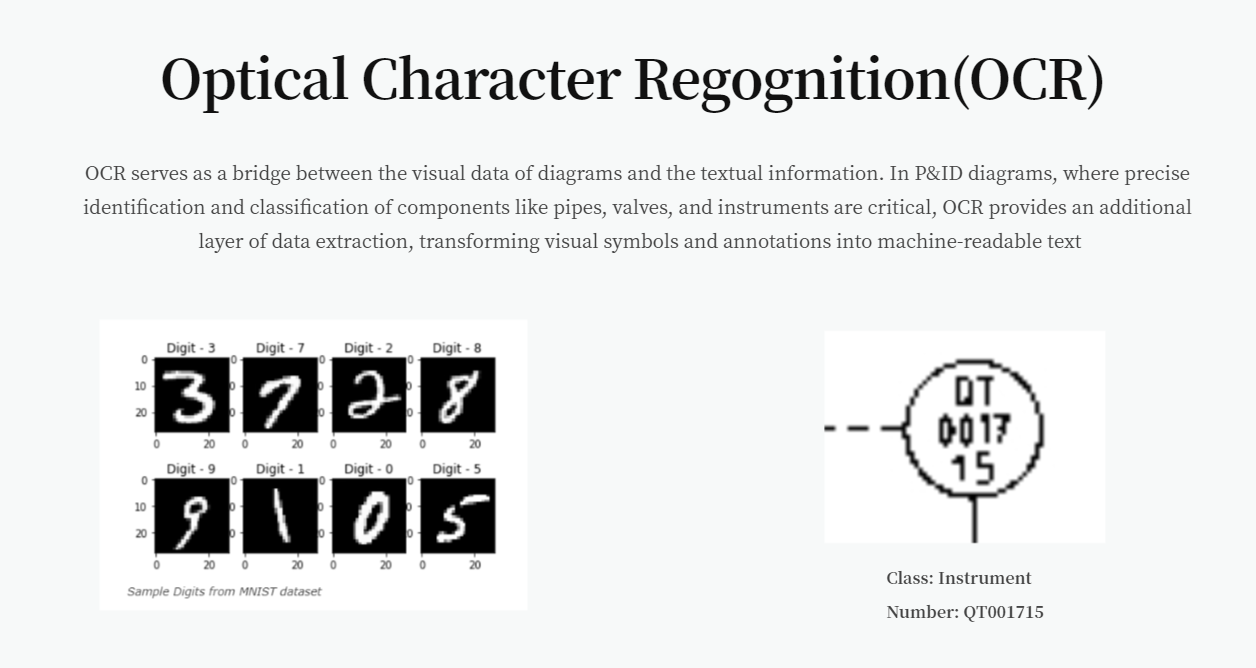

# RapidOCR Extractor

In [ ]:
from rapidocr_onnxruntime import RapidOCR

# OCR extraction class
class RapidOCRTextExtractor:
    def __init__(self, engine):
        self.engine = engine

    def extract_text(self, image_path):
        img = Image.open(image_path)
        open_cv_image = pil_to_cv2(img)
        preprocessed_image = preprocess_for_ocr(open_cv_image)
        result, _ = self.engine(preprocessed_image)
        if result:
            return ' '.join([res[1] for res in result])
        return ''

# Convert PIL image to OpenCV format
def pil_to_cv2(pil_image):
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

# Preprocess image for OCR
def preprocess_for_ocr(image, target_size=(300, 300)):
    # Resize image
    image = cv2.resize(image, target_size)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding for better contrast
    preprocessed_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return preprocessed_image

# Assuming you have enhanced_images from some previous processing
# Update this part accordingly based on your actual code
enhanced_images = cropped_images

# Initialize OCR engine
ocr_engine = RapidOCR()
text_extractor = RapidOCRTextExtractor(ocr_engine)

## Extract text using RapidOCR

In [ ]:
# Extract text from the saved images
texts = {}
for idx in range(len(enhanced_images)):
    image_path = os.path.join(output_folder, f"detected_area_{idx}.png")
    text = text_extractor.extract_text(image_path)
    texts[image_path] = text
# Display cropped images and extracted texts side by side
for idx, (image_path, text) in enumerate(texts.items()):
    img = Image.open(image_path)
    display(img)
    print(f"Extracted Text {idx + 1}: {text}")


In [ ]:
#!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com